# Generative Adversarial Networks: Generating Graphene EM Images

In [VAE_practical.ipynb](../VAE/VAE_practical.ipynb), we have used the inelastic neutron scattering (INS) dataset to train a VAE to generate new images. In this notebook, we train a GAN with the same dataset.

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam

from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# check version
print('Using Pytorch v%s' % torch.__version__)

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
plt.style.use('ggplot')

Using Pytorch v2.3.0


In [2]:
# set the type of device to learn on
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"device: {device}")


device: cuda


In [3]:
# Set random seed for reproducibility
manualSeed = 123
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


In [4]:
# Batch size during training
batch_size = 256

# Batch size for sampling images (for vizualisation)
viz_batch_size = 64

# # Spatial size of training images.
image_size = (20,20)

# Number of channels in the training images. For color images this is 3
num_channels = 1

# Size of z latent vector (i.e. size of generator input)
d_z = 100

# Number of training epochs
num_epochs = 5 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [5]:
# # variables passed to bash; do not change
# project_id = 'sciml-workshop'
# bucket_name = 'sciml-workshop-data'
# colab_data_path = '/content/sciml-workshop-data/'

# try:
#     from google.colab import auth
#     auth.authenticate_user()
#     google_colab_env = 'true'
#     data_path = colab_data_path + 'sciml-workshop/'
# except:
#     google_colab_env = 'false'
#     ###################################################
#     ######## specify your local data path here ########
#     ###################################################
#     with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]
    

In [6]:
# %%bash -s {google_colab_env} {colab_data_path} {bucket_name} 

# # running locally
# if ! $1; then
#     echo "Running notebook locally."
#     exit
# fi

# # already mounted
# if [ -d $2 ]; then
#     echo "Data already mounted."
#     exit
# fi

# apt -qq update
# apt -qq install s3fs fuse
# mkdir -p $2
# s3fs $3 $2 -o allow_other,use_path_request_style,no_check_certificate,public_bucket=1,ssl_verify_hostname=0,host=https://s3.echo.stfc.ac.uk,url=https://s3.echo.stfc.ac.uk

In [7]:
# TODO - TEMP FIX UNTIL DATA STORAGE WORKS!
data_path = "../../workshop_data/sciml-workshop/"

---

# The dataset

The INS dataset contains 20,000 images. This number is insufficient to train a GAN, given that the images are of high variability. Each image has a shape of `(20, 200)`, as composed of 10 images with shape `(20, 20)` in a row. To maximise the number of data, we divide one original image into 10 sub-images and filter out the weak ones. Finally, we obtain a dataset with 129,228 images.

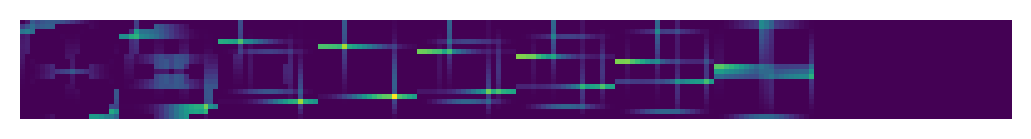

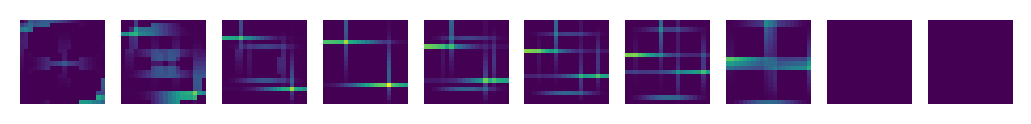

Shape of original dataset: (20000, 20, 200, 1)
Shape of divided dataset: (200000, 20, 20, 1)
Shape of training dataset: (129228, 20, 20, 1)


In [8]:
# read original images
with h5py.File(data_path + 'ins-data/train.h5', 'r') as handle:
    big_images = handle['images'][:]
    
# divide into 10 sub-images
n = big_images.shape[0]
sub_images = np.moveaxis(big_images.reshape([n, 20, 10, 20]), 2, 1).reshape(n * 10, 20, 20, 1)
    
# plot an image and its sub-images
index = 0
plt.figure(dpi=200)
plt.imshow(big_images[index, :, :, 0])
plt.gca().set_aspect(1.)
plt.axis('off')
plt.show()
fig, ax = plt.subplots(1, 10, dpi=200)
for i in range(10):
    ax[i].imshow(sub_images[index * 10 + i, :, :, 0], vmin=0, vmax=1)
    ax[i].set_aspect(1.)
    ax[i].axis('off')
plt.show()

# remove weak ones: max pixel smaller than a given threshold
threshold = 0.5
train_images = sub_images[np.where(np.max(sub_images, axis=(1, 2, 3)) > threshold)]

# normalize to [-1, 1]
train_images = train_images * 2 - 1

# print size info
print(f'Shape of original dataset: {big_images.shape}')
print(f'Shape of divided dataset: {sub_images.shape}')
print(f'Shape of training dataset: {train_images.shape}')

Next, we can create a dataset with the new image set. Note that this dataset will only return images as there are no labels like in the MNIST dataset.  

In [9]:
class INSDataset(Dataset):
    """
    Create a custom Dataset to be able to sample batches of images 
    """
    def __init__(self, images):
        # convert data to Pyotrch Tensor and permute so channel dimension is first, i.e., [B,W,H,C] -> [B,C,W,H]
        self.images = torch.Tensor(images).permute(0,3,1,2)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]
    
dataset = INSDataset(train_images)
# data will be shuffled
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

---

# Create a GAN

Our image size is `(20, 20)`, similar to `mnist`, so we may continue to use the network designed in [GAN_basics.ipynb](GAN_basics.ipynb). 


### The generator

Create a generator network. In the suggested answer, we simply copy from [GAN_basics.ipynb](GAN_basics.ipynb), only changing the image size.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python


class Generator(nn.Module):
    def __init__(self, image_size, n_channels=1, n_latent=100, n_filters=(512,256,128,64)):
        """
       Create a generator, hardcoded with 2 Conv2D layers and 2 Conv2DTranspose layers.

        Args:
            image_size (tuple[int]): Size of generated image (w,h). 
            n_channels (int): Number of channels in the image, e.g. RGB is 3 and greyscale is 1. Defaults to 1.
            n_latent (int): Dimension of (latent) noise vector. Defaults to 100.
            n_filters (tuple[int]): Number of filters in each layer. Defaults to (512,256,128,64).
        """
        super(Generator, self).__init__()
        
        k = 5           # kernel_size
        p = k // 2      # padding
        
        self.d_latent = n_latent
        self.n_filters = n_filters
        
        self.w = image_size[0] // 2**2
        self.h = image_size[1] // 2**2
        wh = self.w*self.h
        
        # input is noise z
        # input shape: (b, nz=100)
        # output shape: (b, 5*5*512)
        self.fc1 = nn.Linear(n_latent, n_filters[0] * wh, bias=False)
        
        self.net = nn.Sequential(
            # input shape: (b, 512, 5, 5)
            # output shape: (b, 512, 5, 5)
            nn.BatchNorm2d(n_filters[0]),
            nn.ReLU(True),
            
            # input shape: (b, 512, 5, 5)
            # output shape: (b, 256, 5, 5)
            nn.Conv2d(n_filters[0], n_filters[1], 
                      kernel_size=k, stride=1, padding=p, bias=False),
            nn.BatchNorm2d(n_filters[1]),
            nn.ReLU(True),
            
            # input shape: (b, 256, 5, 5)
            # output shape: (b, 128, 10, 10)
            nn.ConvTranspose2d(n_filters[1], n_filters[2], 
                               kernel_size=k, stride=2, padding=p, output_padding=1, bias=False),
            nn.BatchNorm2d(n_filters[2]),
            nn.ReLU(True),
            
            # input shape: (b, 128, 10, 10)
            # output shape: (b, 64, 20, 20)
            nn.ConvTranspose2d(n_filters[2], n_filters[3], 
                               kernel_size=k, stride=2, padding=p, output_padding=1, bias=False),
            nn.BatchNorm2d(n_filters[3]),
            nn.ReLU(True),
            
            # input shape: (b, 64, 20, 20)
            # output shape: (b, n_channels, 20, 20)
            nn.Conv2d(n_filters[3], n_channels, 
                      kernel_size=k, stride=1, padding=p, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        # (b, 100) --> (b, 12800)
        out = self.fc1(z)
        # (b, 12800) --> (b, 512, 5, 5)
        out = out.view(out.shape[0], self.n_filters[0], self.w, self.h)
        # (b, 512, 5, 5) --> (b, 1, 20, 20)
        output = self.net(out)
        return output
    
```
    
</p>
</details>


In [10]:

class Generator(nn.Module):
    def __init__(self, image_size, n_channels=1, n_latent=100, n_filters=(512,256,128,64)):
        """
       Create a generator, hardcoded with 2 Conv2D layers and 2 Conv2DTranspose layers.

        Args:
            image_size (tuple[int]): Size of generated image (w,h). 
            n_channels (int): Number of channels in the image, e.g. RGB is 3 and greyscale is 1. Defaults to 1.
            n_latent (int): Dimension of (latent) noise vector. Defaults to 100.
            n_filters (tuple[int]): Number of filters in each layer. Defaults to (512,256,128,64).
        """
        super(Generator, self).__init__()
        
        k = 5           # kernel_size
        p = k // 2      # padding
        
        self.d_latent = n_latent
        self.n_filters = n_filters
        
        self.w = image_size[0] // 2**2
        self.h = image_size[1] // 2**2
        wh = self.w*self.h
        
        # input is noise z
        # input shape: (b, nz=100)
        # output shape: (b, 5*5*512)
        self.fc1 = nn.Linear(n_latent, n_filters[0] * wh, bias=False)
        
        self.net = nn.Sequential(
            # input shape: (b, 512, 5, 5)
            # output shape: (b, 512, 5, 5)
            nn.BatchNorm2d(n_filters[0]),
            nn.ReLU(True),
            
            # input shape: (b, 512, 5, 5)
            # output shape: (b, 256, 5, 5)
            nn.Conv2d(n_filters[0], n_filters[1], 
                      kernel_size=k, stride=1, padding=p, bias=False),
            nn.BatchNorm2d(n_filters[1]),
            nn.ReLU(True),
            
            # input shape: (b, 256, 5, 5)
            # output shape: (b, 128, 10, 10)
            nn.ConvTranspose2d(n_filters[1], n_filters[2], 
                               kernel_size=k, stride=2, padding=p, output_padding=1, bias=False),
            nn.BatchNorm2d(n_filters[2]),
            nn.ReLU(True),
            
            # input shape: (b, 128, 10, 10)
            # output shape: (b, 64, 20, 20)
            nn.ConvTranspose2d(n_filters[2], n_filters[3], 
                               kernel_size=k, stride=2, padding=p, output_padding=1, bias=False),
            nn.BatchNorm2d(n_filters[3]),
            nn.ReLU(True),
            
            # input shape: (b, 64, 20, 20)
            # output shape: (b, n_channels, 20, 20)
            nn.Conv2d(n_filters[3], n_channels, 
                      kernel_size=k, stride=1, padding=p, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        # (b, 100) --> (b, 12800)
        out = self.fc1(z)
        # (b, 12800) --> (b, 512, 5, 5)
        out = out.view(out.shape[0], self.n_filters[0], self.w, self.h)
        # (b, 512, 5, 5) --> (b, 1, 20, 20)
        output = self.net(out)
        return output
    

In [11]:
# see how the input shape changes as it's passed through the different layers of the network
dummy_inp = (1, d_z)
g_summary = summary(Generator(image_size=image_size), dummy_inp, device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 12800]            1,280,000
├─Sequential: 1-2                        [-1, 1, 20, 20]           --
|    └─BatchNorm2d: 2-1                  [-1, 512, 5, 5]           1,024
|    └─ReLU: 2-2                         [-1, 512, 5, 5]           --
|    └─Conv2d: 2-3                       [-1, 256, 5, 5]           3,276,800
|    └─BatchNorm2d: 2-4                  [-1, 256, 5, 5]           512
|    └─ReLU: 2-5                         [-1, 256, 5, 5]           --
|    └─ConvTranspose2d: 2-6              [-1, 128, 10, 10]         819,200
|    └─BatchNorm2d: 2-7                  [-1, 128, 10, 10]         256
|    └─ReLU: 2-8                         [-1, 128, 10, 10]         --
|    └─ConvTranspose2d: 2-9              [-1, 64, 20, 20]          204,800
|    └─BatchNorm2d: 2-10                 [-1, 64, 20, 20]          128
|    └─ReLU: 2-11                        [-1, 64, 20, 2

Here we can use the **untrained** generator to generate an image. This is helpful to validate the layer sizes in the generator.

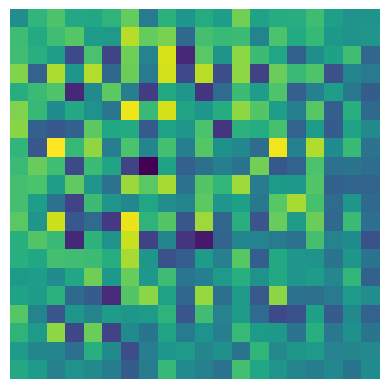

In [12]:
generator = Generator(image_size).to(device)
z = torch.randn(1, d_z, device=device)
# generate and plot the image
generated_image = generator(z)
# reshape to [1,C,W,H] then permute to [1,W,H,C] so channel dimension is at the end (required order for displaying images using imshow). 
generated_image_for_viz = generated_image.reshape(1, num_channels, image_size[0], image_size[1]).permute(0,2,3,1)  
generated_image_for_viz = generated_image_for_viz.detach().cpu()
plt.figure(dpi=100)
plt.imshow(generated_image_for_viz[0])
plt.axis('off')
plt.show()

### The discriminator

Create a discriminator network. In the suggested answer, we simply copy from [GAN_basics.ipynb](GAN_basics.ipynb), only changing the image size.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
class Discriminator(nn.Module):
    def __init__(self, image_size, n_channels=1, n_filters=(64,128,256)):
        """
        Create a discriminator, hardcoded with two Conv2D layers. 

        Args:
            image_size (tuple[int]): Number of channels in the image, e.g. RGC is 3 and greyscale is 1. Defaults to 1.
            n_channels (int): Number of channels in the image, e.g. RGC is 3 and greyscale is 1. Defaults to 1.
            n_filters (tuple[int]): Number of filters in each layer. Defaults to (64,128).
        """
        super(Discriminator, self).__init__()
        
        k = 5           # kernel_size
        p = k // 2      # padding
        
        # The net will downscale the image size three times so the final image size before flattening will be:
        w_final = image_size[0] // 2**3
        h_final = image_size[1] // 2**3
        self.wh_final = w_final*h_final
        
        self.net = nn.Sequential(
            # input is an image (can be real/fake) of shape (b, nc, image_size[0], image_size[1])
            # input shape: (b, 1, 20, 20)
            # output shape: (b, 64, 10, 10)
            nn.Conv2d(n_channels, n_filters[0], 
                      kernel_size=k, stride=2, padding=p, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        
            # input shape: (b, 64, 10, 10)
            # output shape: (b, 128, 5, 5)
            nn.Conv2d(n_filters[0], n_filters[1], 
                      kernel_size=k, stride=2, padding=p, bias=False),
            nn.BatchNorm2d(n_filters[1]),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input shape: (b, 128, 5, 5)
            # output shape: (b, 256, 2, 2)
            nn.Conv2d(n_filters[1], n_filters[2], 
                      kernel_size=k, stride=2, padding=1,  bias=False),
            nn.BatchNorm2d(n_filters[2]),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input shape: (b, 256, 2, 2)
            # output shape: (b, 256*2*2)
            nn.Flatten(start_dim=1),
            
            # input shape: (b, 128*2*2)
            # output shape: (b, 1)
            nn.Linear(n_filters[2]*self.wh_final, 1)
        )
        
    def forward(self, input):
        # (b,1,20,20) -> (b,1)
        return self.net(input)
    
    
```
    
</p>
</details>

In [13]:
class Discriminator(nn.Module):
    def __init__(self, image_size, n_channels=1, n_filters=(64,128,256)):
        """
        Create a discriminator, hardcoded with two Conv2D layers. 

        Args:
            image_size (tuple[int]): Number of channels in the image, e.g. RGC is 3 and greyscale is 1. Defaults to 1.
            n_channels (int): Number of channels in the image, e.g. RGC is 3 and greyscale is 1. Defaults to 1.
            n_filters (tuple[int]): Number of filters in each layer. Defaults to (64,128).
        """
        super(Discriminator, self).__init__()
        
        k = 5           # kernel_size
        p = k // 2      # padding
        
        # The net will downscale the image size three times so the final image size before flattening will be:
        w_final = image_size[0] // 2**3
        h_final = image_size[1] // 2**3
        self.wh_final = w_final*h_final
        
        self.net = nn.Sequential(
            # input is an image (can be real/fake) of shape (b, nc, image_size[0], image_size[1])
            # input shape: (b, 1, 20, 20)
            # output shape: (b, 64, 10, 10)
            nn.Conv2d(n_channels, n_filters[0], 
                      kernel_size=k, stride=2, padding=p, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        
            # input shape: (b, 64, 10, 10)
            # output shape: (b, 128, 5, 5)
            nn.Conv2d(n_filters[0], n_filters[1], 
                      kernel_size=k, stride=2, padding=p, bias=False),
            nn.BatchNorm2d(n_filters[1]),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input shape: (b, 128, 5, 5)
            # output shape: (b, 256, 2, 2)
            nn.Conv2d(n_filters[1], n_filters[2], 
                      kernel_size=k, stride=2, padding=1,  bias=False),
            nn.BatchNorm2d(n_filters[2]),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # input shape: (b, 256, 2, 2)
            # output shape: (b, 256*2*2)
            nn.Flatten(start_dim=1),
            
            # input shape: (b, 128*2*2)
            # output shape: (b, 1)
            nn.Linear(n_filters[2]*self.wh_final, 1)
        )
        
    def forward(self, input):
        # (b,1,20,20) -> (b,1)
        return self.net(input)
    

In [14]:
d = Discriminator(image_size=image_size)
summary = summary(d, (num_channels, image_size[0], image_size[1]), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 10, 10]          1,600
|    └─LeakyReLU: 2-2                    [-1, 64, 10, 10]          --
|    └─Conv2d: 2-3                       [-1, 128, 5, 5]           204,800
|    └─BatchNorm2d: 2-4                  [-1, 128, 5, 5]           256
|    └─LeakyReLU: 2-5                    [-1, 128, 5, 5]           --
|    └─Conv2d: 2-6                       [-1, 256, 2, 2]           819,200
|    └─BatchNorm2d: 2-7                  [-1, 256, 2, 2]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 2, 2]           --
|    └─Flatten: 2-9                      [-1, 1024]                --
|    └─Linear: 2-10                      [-1, 1]                   1,025
Total params: 1,027,393
Trainable params: 1,027,393
Non-trainable params: 0
Total mult-adds (M): 9.59
Input size (MB): 0.00
Forward/backw

Again, for size validation,  we can use the **untrained** discriminator to check the image we just generated.

In [15]:
# check an image
discriminator = Discriminator(image_size).to(device)
decision = discriminator(generated_image)
print(f"Discirminator decision: Probability the image is fake = {decision.item():.2f}")

Discirminator decision: Probability the image is fake = -0.10


---

## Weight Initialization
Define the function to do initalization of weights for the Generator and Discirminator.
In the suggested answer, we simply copy from [GAN_basics.ipynb](GAN_basics.ipynb).

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# custom weights initialization called on ``generator`` and ``discriminator``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
```
    
</p>
</details>

In [16]:
# custom weights initialization called on ``generator`` and ``discriminator``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# Training Loop

Implement the and run the training function for the data a mini-batch. In the suggested answer, we simply copy from [GAN_basics.ipynb](GAN_basics.ipynb) only changing a single line for when we get the batch of data from the dataloader.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# Training Loop
# create fresh generator and discriminator and initalize weights
generator = Generator(image_size, n_channels=num_channels, n_latent=d_z, n_filters=(512,256,128,64)).to(device)
discriminator = Discriminator(image_size, n_channels=num_channels, n_filters=(64,128,256)).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Initialize the loss function
criterion = nn.BCEWithLogitsLoss()

# Setup Adam optimizers for both G and D
optimizer_D = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(viz_batch_size, d_z, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        ###############################################################################################################################
        # THE ONLY LINE DIFFERENT TO THE TRAINING LOOP IN GAN_basics! 
        # unlike in GAN_basics, this time the dataloader will only batches of data without their labels
        real_imgs = data.to(device)
        ###############################################################################################################################
        real_imgs = real_imgs.to(device)
        bsz = real_imgs.shape[0]
        
        # Adversarial ground truths, real=1 and fake=0
        real_labels = torch.full((bsz,), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((bsz,), fake_label, dtype=torch.float, device=device)

        ###############################################################################################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###############################################################################################################################
        optimizer_D.zero_grad()
        # disciminate real images
        out_real = discriminator(real_imgs).view(-1)
        real_loss = criterion(out_real, real_labels)
        
        # discriminate fake iamges generated by generator 
        z = torch.randn(bsz, d_z, device=device)
        fake_imgs = generator(z)
        # we only want to train the discriminator at this point, so we have to stop gradient flow to the generator via .detach()
        out_fake = discriminator(fake_imgs.detach()).view(-1)
        fake_loss = criterion(out_fake, fake_labels)
        
        # total loss
        d_loss = (real_loss + fake_loss) 
        d_loss.backward()
        optimizer_D.step()

        ###############################################################################################################################
        # (2) Update G network: maximize log(D(G(z)))
        ###############################################################################################################################
        optimizer_G.zero_grad()
        # this time we want to train the generator, so we keep the gradients (unlike above where we used .detach())
        out_fake = discriminator(fake_imgs).view(-1)
        # a good generator will be able to trick the discriminator into thinking the image is real
        g_loss = criterion(out_fake, real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        ###############################################################################################################################        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     d_loss.item(), g_loss.item()))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1
```
    
</p>
</details>


In [17]:
# Training Loop
# create fresh generator and discriminator and initalize weights
generator = Generator(image_size, n_channels=num_channels, n_latent=d_z, n_filters=(512,256,128,64)).to(device)
discriminator = Discriminator(image_size, n_channels=num_channels, n_filters=(64,128,256)).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Initialize the loss function
criterion = nn.BCEWithLogitsLoss()

# Setup Adam optimizers for both G and D
optimizer_D = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(viz_batch_size, d_z, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        ###############################################################################################################################
        # THE ONLY LINE DIFFERENT TO THE TRAINING LOOP IN GAN_basics! 
        # unlike in GAN_basics, this time the dataloader will only batches of data without their labels
        real_imgs = data.to(device)
        ###############################################################################################################################
        real_imgs = real_imgs.to(device)
        bsz = real_imgs.shape[0]
        
        # Adversarial ground truths, real=1 and fake=0
        real_labels = torch.full((bsz,), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((bsz,), fake_label, dtype=torch.float, device=device)

        ###############################################################################################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###############################################################################################################################
        optimizer_D.zero_grad()
        # disciminate real images
        out_real = discriminator(real_imgs).view(-1)
        real_loss = criterion(out_real, real_labels)
        
        # discriminate fake iamges generated by generator 
        z = torch.randn(bsz, d_z, device=device)
        fake_imgs = generator(z)
        # we only want to train the discriminator at this point, so we have to stop gradient flow to the generator via .detach()
        out_fake = discriminator(fake_imgs.detach()).view(-1)
        fake_loss = criterion(out_fake, fake_labels)
        
        # total loss
        d_loss = (real_loss + fake_loss) 
        d_loss.backward()
        optimizer_D.step()

        ###############################################################################################################################
        # (2) Update G network: maximize log(D(G(z)))
        ###############################################################################################################################
        optimizer_G.zero_grad()
        # this time we want to train the generator, so we keep the gradients (unlike above where we used .detach())
        out_fake = discriminator(fake_imgs).view(-1)
        # a good generator will be able to trick the discriminator into thinking the image is real
        g_loss = criterion(out_fake, real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        ###############################################################################################################################        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     d_loss.item(), g_loss.item()))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/505]	Loss_D: 1.6362	Loss_G: 1.0895
[0/5][50/505]	Loss_D: 0.2082	Loss_G: 3.4495
[0/5][100/505]	Loss_D: 0.0900	Loss_G: 4.5929
[0/5][150/505]	Loss_D: 0.3056	Loss_G: 4.3992
[0/5][200/505]	Loss_D: 0.2790	Loss_G: 3.9351
[0/5][250/505]	Loss_D: 0.6185	Loss_G: 2.8682
[0/5][300/505]	Loss_D: 0.2192	Loss_G: 5.6769
[0/5][350/505]	Loss_D: 0.1687	Loss_G: 4.3322
[0/5][400/505]	Loss_D: 0.3847	Loss_G: 3.2301
[0/5][450/505]	Loss_D: 0.3927	Loss_G: 4.0673
[0/5][500/505]	Loss_D: 0.4118	Loss_G: 2.1226


/home/ubuntu/miniconda3/envs/sciml_workshop/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[1/5][0/505]	Loss_D: 0.2471	Loss_G: 3.5301
[1/5][50/505]	Loss_D: 0.4093	Loss_G: 3.0923
[1/5][100/505]	Loss_D: 0.4803	Loss_G: 2.7115
[1/5][150/505]	Loss_D: 0.6515	Loss_G: 1.4356
[1/5][200/505]	Loss_D: 0.7128	Loss_G: 3.6027
[1/5][250/505]	Loss_D: 1.0012	Loss_G: 2.7267
[1/5][300/505]	Loss_D: 0.4604	Loss_G: 2.2974
[1/5][350/505]	Loss_D: 0.3017	Loss_G: 2.8075
[1/5][400/505]	Loss_D: 0.4957	Loss_G: 2.7826
[1/5][450/505]	Loss_D: 0.2397	Loss_G: 2.9552
[1/5][500/505]	Loss_D: 0.3700	Loss_G: 3.1398
[2/5][0/505]	Loss_D: 0.3023	Loss_G: 2.7980
[2/5][50/505]	Loss_D: 0.3894	Loss_G: 2.8833
[2/5][100/505]	Loss_D: 0.6570	Loss_G: 4.9888
[2/5][150/505]	Loss_D: 0.3371	Loss_G: 2.4822
[2/5][200/505]	Loss_D: 0.6384	Loss_G: 2.4021
[2/5][250/505]	Loss_D: 0.6952	Loss_G: 2.4589
[2/5][300/505]	Loss_D: 1.0133	Loss_G: 4.1079
[2/5][350/505]	Loss_D: 0.2869	Loss_G: 2.9933
[2/5][400/505]	Loss_D: 0.2739	Loss_G: 3.2635
[2/5][450/505]	Loss_D: 0.2248	Loss_G: 3.3715
[2/5][500/505]	Loss_D: 0.1276	Loss_G: 3.1445
[3/5][0/505]	Los

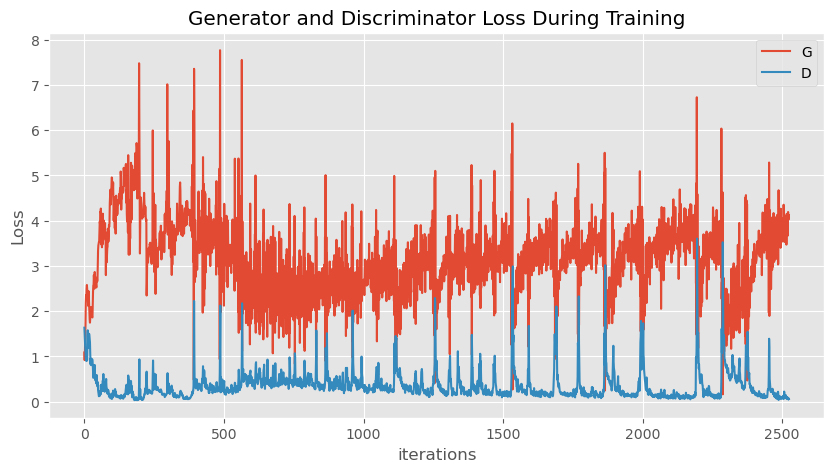

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Finally, use the trained generator to generate images from random noise. In the suggested answer, we simply copy from [GAN_basics.ipynb](GAN_basics.ipynb). 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# seed
nrows = 10
ncols = 10
# seed = tf.random.normal([nrows * ncols, NOISE_SIZE])
seed = torch.randn([nrows * ncols, d_z]).to(device)

# generate images
generator.eval()
with torch.no_grad():
    # input: (100, 100)
    # ouput: (100, 1, 20, 20)
    generated_image = generator(seed)
    # reshape to [B,C,W,H] then permute to [B,W,H,C] so channel dimension is at the end (required order for displaying images using imshow). 
    generated_image_for_viz = generated_image.reshape(nrows*ncols, num_channels, image_size[0], image_size[1]).permute(0,2,3,1)  
    generated_image_for_viz = generated_image_for_viz.detach().cpu()

# plot images
plt.figure(dpi=100, figsize=(ncols, nrows))
for iplot in range(nrows * ncols):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(generated_image_for_viz[iplot, :, :, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()
```
    
</p>
</details>

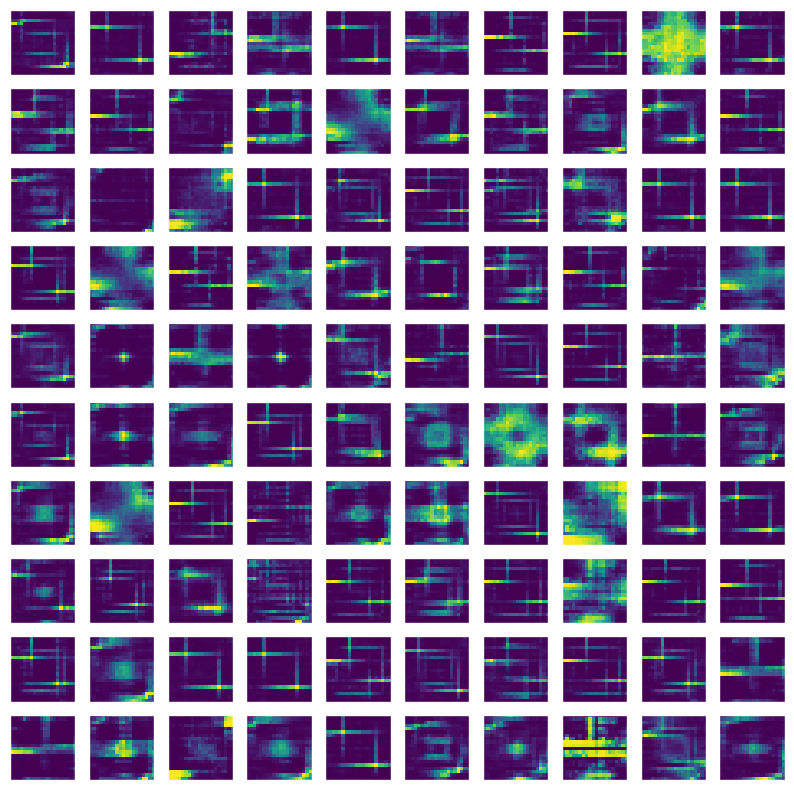

In [19]:
# seed
nrows = 10
ncols = 10
# seed = tf.random.normal([nrows * ncols, NOISE_SIZE])
seed = torch.randn([nrows * ncols, d_z]).to(device)

# generate images
generator.eval()
with torch.no_grad():
    # input: (100, 100)
    # ouput: (100, 1, 20, 20)
    generated_image = generator(seed)
    # reshape to [B,C,W,H] then permute to [B,W,H,C] so channel dimension is at the end (required order for displaying images using imshow). 
    generated_image_for_viz = generated_image.reshape(nrows*ncols, num_channels, image_size[0], image_size[1]).permute(0,2,3,1)  
    generated_image_for_viz = generated_image_for_viz.detach().cpu()

# plot images
plt.figure(dpi=100, figsize=(ncols, nrows))
for iplot in range(nrows * ncols):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(generated_image_for_viz[iplot, :, :, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()

There's seems to be a large gap when comparing the loss of the generator and discriminator. The generator seems to be having a hard time fooling the discrimiator! 

Let's add some dropout to try alliviate this. In the Discriminator, after each `nn.LeakyReLU(0.2, inplace=True),` add the line `nn.Dropout(0.5),`; you should have added 3 dropout layers. Rerun the notebook from the start. 

* Is the generator doing better? 
* Why do you think the loss behaves the way it does? 

Compare the generated results to those generated by a VAE in [VAE_practical.ipynb](../VAE/VAE_practical.ipynb). What can you find?